## Implementación de modelo supervisado de aprendizaje de máquinas para la predicción de alquiler de bicicletas.

Continuando con el ejercicio de análisis estadístico de datos realizado en el articulo anterior, en esta ocasión, implementaremos un modelo predictivo que sirva como bases para la predicción de los valores esperados de alquiler. Para el presente ejercicio utilizaremos la biblioteca PyCaret la cual es una librería open source y bajo requerimiento de código, ideal para un rápido despliegue y desarrollo de modelos tanto supervisados como no supervisados. 

Se puede acceder al sitio web y la documentación de pycaret desde https://pycaret.org. PyCaret es una biblioteca de aprendizaje automático de código abierto y bajo código en Python que le permite pasar de preparar sus datos e implementar su modelo en cuestión de segundos en el entorno de su computadora portátil. PyCaret es una biblioteca “bajo codigo" lo que nos permite escribir menos código y ser más productivos en  menor cantidad de tiempo y concentrarse en lo solución de problemas de ingeniería.  PyCaret es una biblioteca de aprendizaje automático simple y fácil de usar que lo ayudará a realizar experimentos de ML de extremo a extremo con menos líneas de código. 

En adelante se asume que el lector ya tiene instalado PyCaret en su computadora y todas sus dependencias principales, como TensoFlow, PyTorch y Scikit -Learn. 

Tabla de contenidos:
1.	Visualizando la data
2.	Configurando el ambiente
3.	Comparando todos los modelos
4.	Creando el modelo
5.	Afinando el modelo
6.	Graficando el modelo
7.	Predicciones con el modelo
8.	Finalización del modelo
9.	Predicción en nueva data
10.	Guardando el modelo
11.	Cargando el modelo

### 1. Visualizando los datos
Continuando con el ultimo punto de el articulo anterior, visualizamos el comportamiento de la variable alquiler a lo largo del día separado en cada una de las estaciones del año; observamos que en tanto en verano como en otoño se produce la mayor cantidad de alquileres de bicicletas a lo largo del día. De igual manera observamos que el comportamiento de los picos de alquiler se conserva a las horas de inicio y fin de la jornada de trabajo a lo largo del año. En todas las épocas del año el alquiler de bicicletas aumenta gradualmente entre las 8 y las 5 de la tarde independiente de la estación del año.

In [1]:
# Importamos las librerías principales para la manipulación y manejo de los datos 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargamos la base de datos
df = pd.read_csv("bikeSharing_modified_cured.csv")
df.head()

,dteday,year,month,month_int,weekday,weekday_int,hr,workingday,holiday,season,season_int,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,2011,Jan,1,Sat,5,5,0,0,spring,1.0,Slightly cloudy,0.24,0.2576,0.75,0.0896,1
1,2011-01-01,2011,Jan,1,Sat,5,10,0,0,spring,1.0,Clear,0.38,0.3939,0.76,0.2537,36
2,2011-01-01,2011,Jan,1,Sat,5,11,0,0,spring,1.0,Clear,0.36,0.3333,0.81,0.2836,56
3,2011-01-01,2011,Jan,1,Sat,5,12,0,0,spring,1.0,Clear,0.42,0.4242,0.77,0.2836,84
4,2011-01-01,2011,Jan,1,Sat,5,13,0,0,spring,1.0,Slightly cloudy,0.46,0.4545,0.72,0.2985,94


El lector puede observar que fueron retirados todos los Dummy array creados en el articulo anterior, esto con el fin de visualizar el potencial de funcionamiento de la librería PyCaret y los métodos de manejo de los campos que son determinados como ordinales.  

Continuamos con la visualización de la data para observar su comportamiento durante el día. 

[(0.02, 1.0), Text(0, 0.5, 'Temperatura'), None]

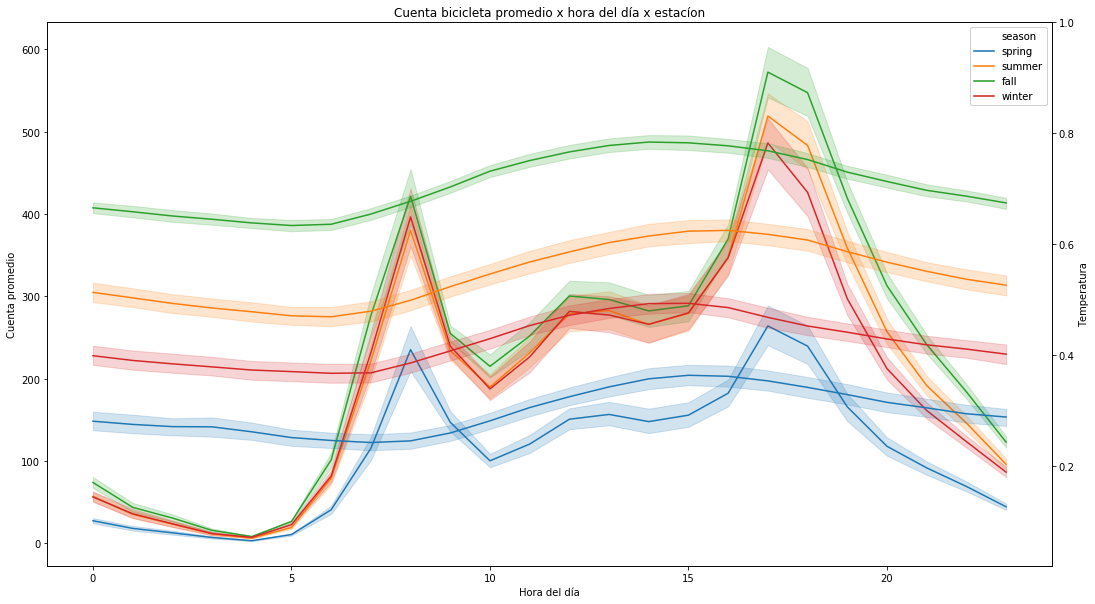

In [3]:
# Visualización de alquiler a lo largo del día vs la temperatura día
plt.figure(figsize=(18,10))
seasonOrder  = ['spring','summer','fall','winter']

ax1 = sns.lineplot(x="hr", y="cnt",hue="season",  hue_order=seasonOrder, data=df)
ax1.set(xlabel='Hora del día', ylabel='Cuenta promedio', 
        title ="Cuenta bicicleta promedio x hora del día x estacíon", label='big')

ax1a = ax1.twinx()
ax1a = sns.lineplot(x="hr", y="temp", hue="season", hue_order=seasonOrder, data=df)
ax1a.set(ylabel='Temperatura', label='big', ylim=(df.temp.min(),df.temp.max())) 

Para demostrar la capacidad de la funcion de prediccion "predict_model ()" en PyCaret en datos no vistos, separaremos una muestra del 10% de los registros del conjunto de datos original para utilizarlos como si se tuviera un conjunto de datos nuevos para utilizar con el modelo entrenado. Esto no debe confundirse con una división de entrenamiento / prueba para la fase iniciarl del ejercicio, ya que esta división particular se realiza para simular un escenario de la vida real.

Otra forma de pensar en esto es que este 10% de registro no están disponibles en el momento en que se realizó el experimento de aprendizaje automático por lo que servirán para simular el caso de que se posea nueva información de campo y se requiera analizar el posible comportamiento de la variable alquiler. 

In [4]:
# Forma de la matriz de datos. 
df.shape

(17379, 17)

In [5]:
# Data para entrenamiento/pruebas
data = df.sample(frac=0.9, random_state=786).reset_index(drop=True)
# Data no vista por el algoritmo para pruebas de campo
data_unseen = df.drop(data.index).reset_index(drop=True)

print('Data para entrenamiento/prueba: ' + str(data.shape))
print('Data no visata para predicciones: ' + str(data_unseen.shape))

Data para entrenamiento/prueba: (15641, 17)
Data no visata para predicciones: (1738, 17)


### 2. Configurando el ambiente
La función setup () inicializa el entorno en PyCaret y crea la canalización de transformación para preparar los datos para el modelado y su posterior despliegue. Se debe llamar a setup () antes de ejecutar cualquier otra función en PyCaret. La función toma dos parámetros obligatorios: un dataframe de pandas y el nombre de la columna de estudio. Todos los demás parámetros son opcionales y se utilizan para personalizar la canalización de preprocesamiento.

In [6]:
# Importamos el modulo completo de regresiones
from pycaret.regression import *

In [7]:
# Creamos el ambiente
exp_regresion = setup(data = data, target = 'cnt', session_id=123) 

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(15641, 17)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Una vez que la configuración se ha ejecutado con éxito, se imprime la tabla de información. La mayor parte de la información está relacionada con la canalización de preprocesamiento que se construye cuando se ejecuta setup (). La mayoría de estas características están fuera del alcance del presente articulo, sin embargo, algunas cosas importantes a tener en cuenta en esta etapa incluyen:

* session_id: un número pseduo-random utilizado como semilla en todas las funciones para su posterior reproducibilidad. 
* Original Data: muestra la forma original del conjunto de datos. 
* Missing Values: cuando faltan valores en los datos originales, esto se mostrará como Verdadero
* Numeric Features: Número de características inferidas como numéricas. 
* Categorical Features: Número de características inferidas como categóricas. 
* Transformed Train Set: muestra la forma del conjunto de entrenamiento transformado.
* Transformed Test Set: muestra la forma del conjunto de prueba transformado. 

Si encontramos que PyCaret no ha reconocido de manera adecuada las características numéricas o categóricas, debemos especificar la lista de cada uno de los factores y pasarlos como opción en la función Setup().

### 3. Comparando todos los modelos
La comparación de todos los modelos con el fin de evaluar su rendimiento, es el punto de partida recomendado para modelar en PyCaret, una vez que se completa la configuración inicial. A menos que sepa exactamente qué tipo de modelo necesita, que a menudo no es el caso, es recomendable realizar esta labor inicialmente. Esta función entrena todos los modelos de la biblioteca y los califica usando la validación cruzada "kfold" para su evaluación métrica. El resultado nos entrega una tabla de puntaje que muestra el promedio de MAE, MSE, RMSE, R2, RMSLE y MAPE en cada uno de los pliegues (10 por defecto) de todos los modelos disponibles.

In [8]:
# Realizamos la camparación de los modelos.
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,27.126200,1805.339800,42.420900,0.945500,0.452600,0.461100
1,Light Gradient Boosting Machine,26.886900,1808.777000,42.475500,0.945400,0.423200,0.425100
2,Extra Trees Regressor,26.849100,1908.064900,43.628100,0.942300,0.350000,0.329100
3,Random Forest,27.730800,2075.647800,45.530100,0.937200,0.356300,0.333400
4,Decision Tree,37.137900,3974.205600,62.895600,0.879700,0.459100,0.397600
5,K Neighbors Regressor,42.560300,4508.607400,67.063800,0.863900,0.440400,0.467600
6,Gradient Boosting Regressor,47.792600,4892.228900,69.867200,0.852200,0.672900,0.932600
7,Extreme Gradient Boosting,48.758000,5106.279100,71.332200,0.845900,0.681000,0.964300
8,AdaBoost Regressor,90.423400,11955.342500,109.273000,0.637000,1.137900,3.291000
9,Bayesian Ridge,104.624600,19574.533800,139.829500,0.408200,1.206800,3.417700


Dos palabras simples de código (ni siquiera una línea) han creado más de 22 modelos utilizando una validación cruzada con 10 pliegues y evaluando las 6 métricas de regresión más utilizadas (MAE, MSE, RMSE, R2, RMSLE y MAPE). La cuadrícula de puntaje impresa resalta la métrica de mayor rendimiento solo para fines de comparación.

### 4. Creando el modelo
Si bien compare_models () es una función poderosa y, a menudo, un punto de partida en cualquier experimento, no devuelve ningún modelo entrenado. El flujo de trabajo para experimentos recomendado por PyCaret es usar compare_models () justo después de la configuración inicial del ambiente, para evaluar los modelos de mejor rendimiento y finalizar con algunos candidatos para la experimentación continua. Como tal, la función que realmente le permite crear un modelo se llama sin imaginación create_model (). Esta función crea un modelo y lo puntúa mediante validación cruzada estratificada. Similar a compare_models (), la salida imprime una cuadrícula de puntaje que muestra MAE, MSE, RMSE, R2, RMSLE y MAPE por pliegue.

Para continuar el ejercicio utilizaremos los estimadores Catboost, Light Gradient Boosting Machine y Extra Trees Regressor ya que son los que mejor desempeño mostraron a la hora de realizar la comparación.

In [9]:
# Creamos un modelo con estimador Catboost
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,28.6201,1992.5919,44.6385,0.9393,0.4664,0.4138
1,26.8941,1863.9108,43.1730,0.9452,0.4645,0.5045
2,24.9216,1565.7115,39.5691,0.9505,0.4293,0.4239
3,26.6370,1662.0278,40.7680,0.9447,0.4472,0.4524
4,25.5718,1478.8351,38.4556,0.9518,0.4593,0.4889
5,27.4343,1927.9788,43.9088,0.9384,0.4715,0.4726
6,26.0422,1765.6189,42.0193,0.9483,0.4340,0.4576
7,27.9191,1823.8064,42.7060,0.9475,0.4638,0.4595
8,27.8741,1742.5669,41.7441,0.9512,0.4443,0.4354
9,29.3474,2230.3499,47.2266,0.9378,0.4453,0.5023


In [10]:
# Creamos un modelo Light Gradient Boosting Machine 
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27.8180,1888.6221,43.4583,0.9424,0.4214,0.3840
1,26.8121,1845.1681,42.9554,0.9457,0.4521,0.5126
2,25.1979,1640.8814,40.5078,0.9481,0.4309,0.4157
3,26.2638,1612.1434,40.1515,0.9464,0.4130,0.4028
4,25.5430,1540.0441,39.2434,0.9498,0.4377,0.4374
5,26.9815,1906.6102,43.6647,0.9391,0.4237,0.4159
6,26.2508,1796.9883,42.3909,0.9474,0.4322,0.4521
7,27.5494,1852.2544,43.0378,0.9467,0.3976,0.3876
8,27.8407,1768.0339,42.0480,0.9505,0.4018,0.4174
9,28.6119,2237.0245,47.2972,0.9376,0.4212,0.4258


In [11]:
# Imprimimos las características del modelo.
print(lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [12]:
# Creamos el modelo Extra Trees Regressor
extratrees = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26.6910,1893.0700,43.5094,0.9423,0.3565,0.3262
1,26.3579,1941.3434,44.0607,0.9429,0.3624,0.3464
2,25.7310,1882.1827,43.3841,0.9405,0.3416,0.3114
3,27.3342,1789.6605,42.3044,0.9404,0.3454,0.3139
4,24.5665,1522.2927,39.0166,0.9503,0.3302,0.3062
5,27.6109,2133.9893,46.1951,0.9318,0.3378,0.3090
6,26.6893,1835.3764,42.8413,0.9462,0.3742,0.3537
7,27.1147,1881.0764,43.3714,0.9458,0.3503,0.3542
8,27.7222,1934.7696,43.9860,0.9459,0.3541,0.3136
9,28.6731,2266.8884,47.6119,0.9368,0.3475,0.3565


In [13]:
# Imprimimos las características del modelo.
print(extratrees)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


### 5. Afinando el modelo
Cuando se crea un modelo utilizando la función create_model (), utiliza los hiperparámetros predeterminados. Para ajustar hiperparámetros, se utiliza la función tune_model (). Esta función ajusta automáticamente los hiperparámetros de un modelo en un espacio de búsqueda predefinido y lo califica utilizando la validación cruzada kfold. La salida imprime una cuadrícula de puntaje que muestra MAE, MSE, RMSE, R2, RMSLE y MAPE por pliegue.

In [14]:
# Creamos el proceso automático de ajustes finos para el modelo CatBoost
tuned_cat = tune_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,30.5839,2102.6617,45.8548,0.9359,0.5149,0.5291
1,28.9026,1991.7094,44.6286,0.9414,0.5457,0.6369
2,26.5424,1710.7015,41.3606,0.9459,0.5106,0.5595
3,29.7199,1915.8222,43.7701,0.9362,0.5453,0.6395
4,27.0385,1564.8790,39.5586,0.9490,0.5620,0.6738
5,30.0202,2149.2769,46.3603,0.9313,0.5304,0.5987
6,28.2754,1922.4651,43.8459,0.9437,0.5260,0.6159
7,28.9692,1923.6085,43.8590,0.9446,0.5479,0.5669
8,30.2449,1989.6061,44.6050,0.9443,0.5199,0.5343
9,31.2775,2353.9781,48.5178,0.9343,0.5339,0.6451


In [15]:
# Creamos el proceso automático de ajustes finos para el modelo Light Gradient Boosting Machine
tuned_lightgbm = tune_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,25.9727,1747.4507,41.8025,0.9467,0.4249,0.3616
1,25.9291,1732.6161,41.6247,0.9490,0.4443,0.4249
2,24.7374,1691.2330,41.1246,0.9465,0.3991,0.3802
3,25.9577,1540.8314,39.2534,0.9487,0.4166,0.3887
4,25.4363,1536.9647,39.2041,0.9499,0.4442,0.4133
5,25.9127,1717.6486,41.4445,0.9451,0.4145,0.4067
6,25.7647,1706.0929,41.3049,0.9500,0.4461,0.4129
7,27.0167,1864.3774,43.1784,0.9463,0.4188,0.3745
8,26.9253,1762.5785,41.9831,0.9507,0.4006,0.3497
9,27.2816,2073.9530,45.5407,0.9421,0.4203,0.4299


In [16]:
# Imprimimos las características del modelo ajustado
print(tuned_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
              n_estimators=100, n_jobs=-1, num_leaves=70, objective=None,
              random_state=123, reg_alpha=0.1, reg_lambda=0.5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [17]:
# Creamos el proceso automático de ajustes finos para el modelo Extra Trees Regressor
tuned_extratrees= tune_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27.0785,1906.0900,43.6588,0.9419,0.3599,0.3334
1,27.3046,2031.0015,45.0666,0.9402,0.3725,0.3689
2,25.7146,1880.2309,43.3616,0.9405,0.3350,0.3060
3,27.0580,1762.0560,41.9769,0.9414,0.3412,0.3132
4,24.8857,1568.4741,39.6040,0.9488,0.3399,0.3238
5,26.8118,1941.6935,44.0647,0.9380,0.3390,0.3174
6,26.4562,1845.5098,42.9594,0.9459,0.3690,0.3508
7,27.7412,1990.6683,44.6169,0.9427,0.3446,0.3314
8,28.6036,1948.4286,44.1410,0.9455,0.3665,0.3372
9,29.2929,2346.5804,48.4415,0.9345,0.3450,0.3394


In [18]:
# Imprimimos las características del modelo ajustado
print(tuned_extratrees)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=70, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=7, min_weight_fraction_leaf=0.0,
                    n_estimators=170, n_jobs=None, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


La función tune_model () es una búsqueda aleatoria de hiperparámetros en un espacio de búsqueda predefinido. De forma predeterminada, está configurado para optimizar R2, pero esto se puede cambiar usando el parámetro de optimización. Por ejemplo: tune_model ('dt', optimizar = 'MAE') buscará los hiperparámetros de un árbol de decisión que resulten en el MAE más bajo (menor es mejor).

### 6. Graficando el modelo
Del análisis realizado anteriormente que el modelo con mejor puntaje promedio de R2 es el modelo Light Gradient Boosting Machine. Por lo anterior continuaremos trabajando con este modelo para realizar la predicción inicial del 30% de los datos para entrenamiento y del 10% restante para la predicción final de los datos no utilizados hasta el momento. 

Antes de la finalización del modelo, la función plot_model () se puede utilizar para analizar el rendimiento en diferentes aspectos, tales como Gráfico de residuos, Error de predicción, importancia de la función, etc. Esta función toma un objeto de modelo entrenado y devuelve un gráfico basado en la prueba / retención conjunto.

#### 6.1 Grafico de residuales:

Un gráfico residual es un gráfico que muestra los residuos en el eje vertical y la variable independiente en el eje horizontal. La diferencia entre el valor observado de la variable dependiente (y) y el valor predicho (ŷ) se llama residual (e). Si los puntos en un gráfico residual se dispersan aleatoriamente alrededor del eje horizontal, un modelo de regresión lineal es apropiado para los datos; de lo contrario, un modelo no lineal es más apropiado.

Para nuestro caso observamos que gran parte de los residuales están dispersos a lo largo del eje x por lo que asumimos que el modelo seleccionado aplica para el ejercicio.

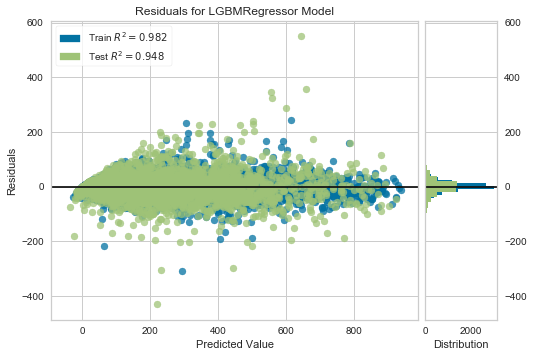

In [19]:
# Función plot_model con el uso del modelo mejorado, sin parámetros adicionales nos muestra el grafico de residuales
plot_model(tuned_lightgbm)

#### 6.2 Curva de aprendizaje
La curva de aprendizaje visualiza el efecto del numero de observaciones en el rendimiento del modelo. Para nuestro caso observamos la estabilización de la curva después de 9000 iteraciones mantenimiento un excelente resultado en la predicción. 


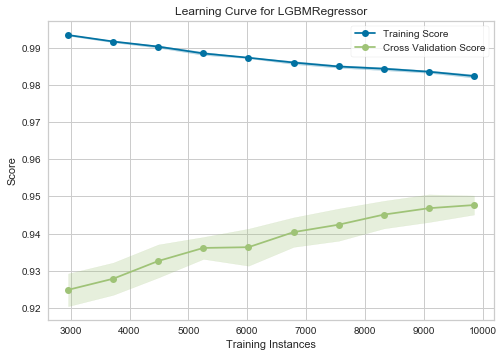

In [20]:
# Función plot_model con el uso del modelo mejorado, parámetro de curva de aprendizaje.
plot_model(estimator = tuned_lightgbm, plot = 'learning')

#### 6.3 Curva de validación
La curva de aprendizaje visualiza la métrica de rendimiento sobre un rango de valores de algunos hiper parámetros.  

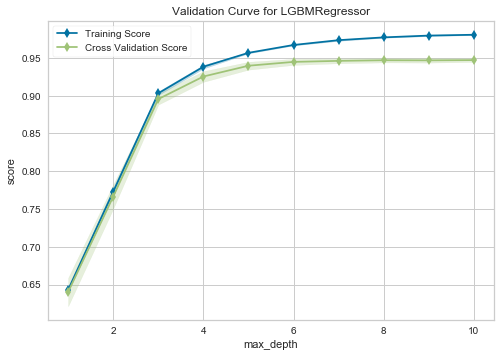

In [21]:
# Función plot_model con el uso del modelo mejorado, parámetro de curva de validación. 
plot_model(estimator = tuned_lightgbm, plot = 'vc')

#### 6.4 Curva del error de predicción

Es un método simple para verificar qué está mal con un modelo de aprendizaje automático. Por lo general, cuando creamos un modelo de regresión, nos preocupa la métrica de error que describe qué tan bien se ajusta a los datos. Por ejemplo, podemos usar el error cuadrático medio. ¿Qué nos dice esto? No mucho. Solo nos dice que el error medio cuadrado tiene un valor aproximado X, esta una descripción muy precisa del error. Tal métrica es útil cuando debemos comparar dos modelos diferentes.
Por otra parte, es completamente inútil cuando debemos explicar en qué caso nuestro modelo está equivocado. Si lo único que sabemos es RMSE (o cualquier otra métrica), no hay forma de saber si el modelo comete muchos errores pequeños o algunos errores enormes. ¿Qué podemos hacer al respecto? Un viejo cliché dice que "Una imagen vale más que mil palabras". Por lo tanto, podemos dibujar un diagrama de dispersión como este:

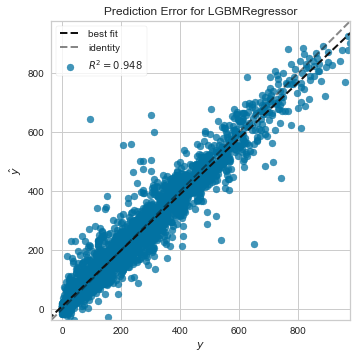

In [22]:
# Función plot_model con el uso del modelo mejorado, parámetro de error de predicción. 
plot_model(tuned_lightgbm, plot = 'error')

#### 6.5 Importancia de los factores de la predicción. 
Una ventaja de usar los algoritmos de incremento de gradiente es que después de que se construyen los árboles aumentados, es relativamente sencillo recuperar puntajes de importancia para cada atributo.
En general, la importancia de cada atributo proporciona una puntuación que indica qué tan útil o valiosa fue cada característica en la construcción de los árboles de decisión potenciados dentro del modelo. Cuanto más se usa un atributo para tomar decisiones clave con árboles de decisión, mayor es su importancia relativa.
Esta importancia se calcula explícitamente para cada atributo en el conjunto de datos, lo que permite clasificar y comparar los atributos entre sí.
La importancia se calcula para un solo árbol de decisión por la cantidad de que cada punto de división de atributo mejora la medida de rendimiento, ponderada por el número de observaciones de las que es responsable el nodo. La medida del rendimiento puede ser la pureza (índice de Gini) utilizada para seleccionar los puntos de división u otra función de error más específica.
Las características importantes se promedian en todos los árboles de decisión dentro del modelo.

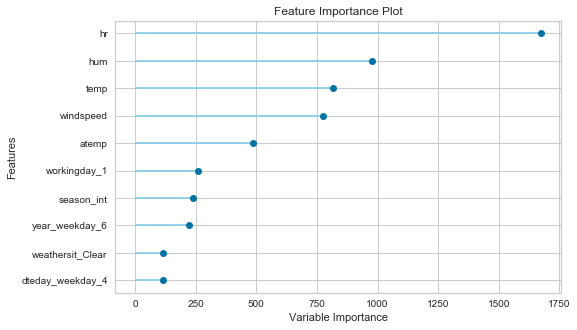

In [23]:
# Función plot_model con el uso del modelo mejorado, parámetro importancia de componentes. 
plot_model(tuned_lightgbm, plot='feature')

#### 6.6 Evaluación del modelo
Finalmente podemos evaluar el modelo y obtener sus principales características de funcionamiento. 

In [24]:
# Metodo para la evaluación del modelo. 
evaluate_model(tuned_lightgbm)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1
importance_type,split
learning_rate,0.2
max_depth,30
min_child_samples,20
min_child_weight,0.001
min_split_gain,0
n_estimators,100


### 7. Predicción del modelo:

Antes de finalizar el modelo, es aconsejable realizar una verificación final prediciendo el conjunto de entrenamiento / prueba y revisar las métricas de evaluación. Si observa la cuadrícula de información en la Sección 2, verá que el 30% (4693 muestras) de los datos se ha separado como una muestra de prueba. Todas las métricas de evaluación que hemos visto anteriormente son resultados con validación cruzada basados únicamente en el conjunto de entrenamiento (70%). Ahora, usando nuestro modelo entrenado final almacenado en la variable tuned_lightgbm, predeciremos la muestra de retención y evaluaremos las métricas para ver si son materialmente diferentes a los resultados del proceso de validación cruzada.

In [25]:
# Método de predicción del modelo ajustado.
predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,25.1474,1660.5288,40.7496,0.9485,0.4249,0.3907


El R2 en el conjunto de prueba es 0.9485 en comparación con 0.9475 logrado en los resultados de validación cruzada de tuned_lightgbm.  Esta no es una diferencia significativa. Si hay una gran variación entre la prueba y los resultados de CV, esto normalmente indicaría un ajuste excesivo, pero también podría deberse a varios otros factores y requeriría una mayor investigación. 

### 8. Finalización del modelo
La finalización del modelo es el último paso en el experimento. Un flujo de trabajo normal de aprendizaje automático en PyCaret comienza con setup (), seguido de comparar todos los modelos usando compare_models () y preseleccionar algunos modelos candidatos (basados en la métrica de interés) para realizar varias técnicas de modelado, como ajuste de hiperparámetros, ensamblaje, apilamiento, etc. Este flujo de trabajo eventualmente lo llevará al mejor modelo para usar para hacer predicciones sobre datos nuevos e invisibles.
 La función finalize_model () ajusta el modelo en el conjunto de datos completo, incluida la muestra de prueba (30% en este caso). El propósito de esta función es entrenar el modelo en el conjunto de datos completo antes de que se implemente en producción.

In [26]:
# Finalización del modelo
final_lightgbm = finalize_model(tuned_lightgbm)

In [27]:
# Imprimimos las características del modelo final
print(final_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
              n_estimators=100, n_jobs=-1, num_leaves=70, objective=None,
              random_state=123, reg_alpha=0.1, reg_lambda=0.5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


Finalmente hacemos la predicción con el modelo finalizado, una vez que el modelo se finaliza utilizando finalize_model (), todo el conjunto de datos, incluido el conjunto de prueba se utiliza para el entrenamiento.
Observe cómo el R2 en final_lightgbm ha aumentado a 0.9782 desde 0.9485, a pesar de que el modelo es el mismo. Esto se debe a que la variable final_lightgbm se entrena en el conjunto de datos completo, incluido el conjunto de prueba.

In [28]:
# Predicción sobre el 90% de los datos 
predict_model(final_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.0719,701.7185,26.49,0.9782,0.346,0.2984


,hr,season_int,temp,atemp,hum,windspeed,month_Jan,month_int_10,month_int_11,month_int_3,...,dteday_weekday_4,dteday_weekday_6,dteday_is_month_end_1,dteday_is_month_start_1,year_month_1,year_weekday_6,year_is_month_end_0,year_is_month_start_1,cnt,Label
0,16.0,4.0,0.50,0.4848,0.63,0.089600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,248,239.6701
1,0.0,3.0,0.72,0.6667,0.48,0.089600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,191,155.0416
2,18.0,2.0,0.50,0.4848,0.94,0.388100,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,38,102.6350
3,21.0,3.0,0.70,0.6667,0.74,0.194000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,211,206.8191
4,0.0,1.0,0.34,0.3030,0.49,0.417900,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,40,36.1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,15.0,1.0,0.36,0.3182,0.32,0.522400,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,334,325.1677
4689,0.0,2.0,0.70,0.6667,0.79,0.089600,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,29,34.0746
4690,13.0,3.0,0.80,0.7121,0.41,0.194000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,176,185.7723
4691,6.0,2.0,0.58,0.5455,0.88,0.165083,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,112,97.0083


### 9. Prediccion en data no utilizada
La función predict_model () también se usa para predecir en el conjunto de datos no visto. La única diferencia con respecto a la sección anterior es que esta vez pasaremos el parámetro data_unseen. data_unseen es la variable creada al comienzo del tutorial y contiene el 10% del conjunto de datos original que nunca estuvo expuesto a PyCaret.

In [29]:
# Predicción sobre el 10% de los datos  no vistos por el modelo
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,dteday,year,month,month_int,weekday,weekday_int,hr,workingday,holiday,season,season_int,weathersit,temp,atemp,hum,windspeed,cnt,Label
0,2011-07-07,2011,Jul,7,Thu,3,12,1,0,fall,3.0,Clear,0.84,0.7727,0.41,0.217541,171,169.7104
1,2011-07-07,2011,Jul,7,Thu,3,13,1,0,fall,3.0,Clear,0.86,0.7879,0.41,0.211789,155,140.2310
2,2011-07-07,2011,Jul,7,Thu,3,23,1,0,fall,3.0,Clear,0.72,0.6818,0.66,0.192826,129,110.4842
3,2011-07-08,2011,Jul,7,Fri,4,1,1,0,fall,3.0,Clear,0.72,0.6970,0.79,0.138959,34,24.1405
4,2011-07-09,2011,Jul,7,Sat,5,16,0,0,fall,3.0,Clear,0.82,0.7273,0.38,0.190159,416,394.2620


### 10. Guardando el modelo
Ahora hemos terminado el experimento finalizando el modelo tuned_lightgbm y está almacenado en la variable final_lightgbm. También hemos utilizado el modelo almacenado en final_lightgbm para predecir data_unseen. Esto nos lleva al final de nuestro experimento, pero todavía queda una pregunta: ¿qué sucede cuando tiene más datos nuevos para predecir? ¿Tienes que volver a realizar todo el experimento? La respuesta es no, la función incorporada de PyCaret save_model () le permite guardar el modelo junto con toda la canalización de transformación para su uso posterior.

In [30]:
# Método para guardar los modelos entrenados en PyCaret
save_model(final_lightgbm,'Final Lightgbm Model 14Jun2020')

Transformation Pipeline and Model Succesfully Saved


### 11. Cargando el modelo
Para cargar un modelo guardado en una fecha futura en el mismo entorno o en otro alternativo, usaríamos la función load_model () de PyCaret y luego aplicaríamos fácilmente el modelo guardado en nuevos datos no vistos para la predicción.

In [31]:
# Método para cargar los modelos entrenados en PyCaret
saved_final_lightgbm = load_model('Final Lightgbm Model 14Jun2020')

Transformation Pipeline and Model Sucessfully Loaded


Una vez que el modelo se carga en el entorno, simplemente puede usarlo para predecir cualquier dato nuevo usando la misma función predict_model (). A continuación, hemos aplicado el modelo cargado para predecir los mismos datos no vistos que utilizamos en la sección anterior. Nótese que los resultados de unseen_prediction y new_prediction son idénticos.

In [32]:
# Predicción sobre la data no vista por el modelo hasta el momento.
new_prediction = predict_model(saved_final_lightgbm, data=data_unseen)
new_prediction.head()

,dteday,year,month,month_int,weekday,weekday_int,hr,workingday,holiday,season,season_int,weathersit,temp,atemp,hum,windspeed,cnt,Label
0,2011-07-07,2011,Jul,7,Thu,3,12,1,0,fall,3.0,Clear,0.84,0.7727,0.41,0.217541,171,169.7104
1,2011-07-07,2011,Jul,7,Thu,3,13,1,0,fall,3.0,Clear,0.86,0.7879,0.41,0.211789,155,140.2310
2,2011-07-07,2011,Jul,7,Thu,3,23,1,0,fall,3.0,Clear,0.72,0.6818,0.66,0.192826,129,110.4842
3,2011-07-08,2011,Jul,7,Fri,4,1,1,0,fall,3.0,Clear,0.72,0.6970,0.79,0.138959,34,24.1405
4,2011-07-09,2011,Jul,7,Sat,5,16,0,0,fall,3.0,Clear,0.82,0.7273,0.38,0.190159,416,394.2620


Realizó:

_Javier A. Ochoa M.  
Ing. Mecánico especialista en gestión de mantenimiento <br />
técnicas de mantenimiento predictivo y confiabilidad integral. <br />
+57-3213192915  
ruslombia@gmail.com  
Bogotá – Colombia_  